In [ ]:
#|default_exp conv

# Convolutions

In [ ]:
#|export
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from pathlib import Path
from torch import tensor
from fastcore.test import test_close
import deeplake
from sklearn.model_selection import train_test_split

from torch.utils.data import default_collate
from collections import Counter
from typing import Mapping

from minai.training import *
from minai.datasets import * 

torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

ds = deeplake.load('hub://activeloop/not-mnist-small', read_only=True, verbose=False)

images = ds.tensors['images'].numpy().reshape(-1, 784).astype('float32')
labels = ds.tensors['labels'].numpy().squeeze(-1).astype('int')

x_train, x_valid, y_train, y_valid = train_test_split(images, labels, test_size=0.2, random_state=1)
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
x_train, x_valid = x_train/255., x_valid/255.

/Users/anubhavmaity/mambaforge/envs/fastai/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.19) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In the context of an image, a feature is a visually distinctive attribute. For example, the number 7 is characterized by a horizontal edge near the top of the digit, and a top-right to bottom left diagonal edge underneath that

It turns out that finding the edges in an image is a very common tasks in computer vision, and is surprisingly straightforward. To do it, we use a convolution. A convolution requires nothing more than multiplication, and addition.

## Understanding the Convolution Equations

To explain the math behind convolutions, fast.ai student Matt Kleinsmith came up with the very clever idea of showing CNNs from different viewpoints

Here's the input:
<p align="center">
  <img src="images/att_00032.png" alt="Grid of 3 by 3 having cells with values A, B, C, D, E, F, G, H, I">
</p>


Here's our kernel:
<p align="center">
  <img src="images/att_00033.png" alt="Grid of 2 by 2 having cells with values &alpha;, &beta;, &gamma;, &delta;">
</p>

Since the filter fits in the image four times, we have four results:
<p align="center">
  <img src="images/att_00034.png" alt="Grid of 2 by 2 having cells with values P, Q, R, S">
</p>

<p align="center">
  <img src="images/att_00035.png" alt="&alpha;, &beta;, &gamma;, &delta; applied to A, B, D, E yields P
                                       &alpha;, &beta;, &gamma;, &delta; applied to B, C, E, F yields Q
                                       &alpha;, &beta;, &gamma;, &delta; applied to D, E, G, H yields R
                                       &alpha;, &beta;, &gamma;, &delta; applied to E, F, H, J yields S">
</p>

In [ ]:
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

In [ ]:
mpl.rcParams['figure.dpi'] = 30

torch.Size([28, 28])

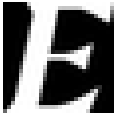

In [ ]:
im3 = x_imgs[8]
show_image(im3);
im3.shape

In [ ]:
top_edge = tensor([[-1, -1, -1],
                   [0,   0,  0],
                   [1,   1,  1]]).float()

We're going to call this our kernel(becase that's what fancy computer vision researchers call these.)

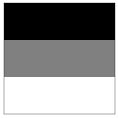

In [ ]:
show_image(top_edge, noframe=False);

The filter will take any window of 3X3 in our images, and if we name the pixel values like this:

\begin{matrix} a1 & a2 & a3 \\ a4 & a5 & a6 \\ a7 & a8 & a9 \end{matrix}

It will return $-a1-a2-a3+a7+a8+a9$

In [ ]:
df = pd.DataFrame(im3[:23, :23])
df.style.format(precision=2).set_properties(**{'font-size': '7pt'}).background_gradient('binary')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.04,0.80,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.99
1,0.00,0.00,0.00,0.00,0.01,0.00,0.27,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.79,0.77,0.78,0.78,0.77,0.80,0.95,1.00,1.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.69,1.00,0.99,1.00,0.99,1.00,0.82,0.02,0.00,0.00,0.00,0.00,0.00,0.11,0.44,0.86
3,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.56,1.00,0.98,1.00,0.99,1.00,0.62,0.00,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.05
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.75,1.00,0.99,1.00,0.98,1.00,0.42,0.00,0.02,0.00,0.00,0.00,0.00,0.01,0.02,0.01
5,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.93,1.00,1.00,1.00,1.00,1.00,0.26,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.01,0.00,0.23,1.00,1.00,1.00,0.99,1.00,0.90,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.02,0.00,0.44,1.00,0.99,1.00,0.99,1.00,0.78,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.02,0.00,0.62,1.00,0.98,1.00,0.99,1.00,0.58,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01
9,0.00,0.00,0.00,0.00,0.00,0.03,0.78,1.00,0.99,1.00,0.99,1.00,0.36,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00


In [ ]:
(im3[11:14, 13:16] * top_edge).sum()

tensor(3.00)

In [ ]:
im3[11:14, 13:16]

tensor([[0.00, 0.00, 0.00],
        [0.13, 0.12, 0.14],
        [1.00, 1.00, 1.00]])

In [ ]:
(im3[13:16, 13:16] * top_edge).sum()

tensor(-2.99)

In [ ]:
im3[13:16, 13:16]

tensor([[1.00, 1.00, 1.00],
        [0.67, 0.67, 0.71],
        [0.00, 0.00, 0.00]])

In [ ]:
def apply_kernel(row, col, kernel): return (im3[row-1:row+2, col-1:col+2] * kernel).sum()

In [ ]:
apply_kernel(4, 15, top_edge)

tensor(-0.01)

<p align="center">
  <img src="images/chapter9_nopadconv.svg" alt="Applying kernel of 3 by 3 on Grid of 5 by 5 with stride 1 along the first 3 rows">
</p>

In [ ]:
[[(i, j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

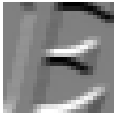

In [ ]:
rng = range(1, 27)
top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])
show_image(top_edge3);

In [ ]:
left_edge = tensor([[-1, 1, 0],
                    [-1, 1, 0],
                    [-1, 1, 0]]).float()

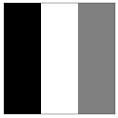

In [ ]:
show_image(left_edge, noframe=False);

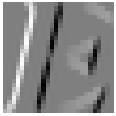

In [ ]:
left_edge3 = tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])
show_image(left_edge3);

<p align="center">
  <img src="images/att_00028.png" alt="Applying kernel of 3 by 3 on Grid of 4 by 4 with stride 1 and getting outputs of grid of 2 by 2">
</p>

Output shape Equation:  
$$  \frac{n - f + 2 \times p}{s} + 1 $$

## Convolutions in PyTorch

In [ ]:
import torch.nn.functional as F
import torch

What to do if you have [2 months to complete your thesis](https://github.com/Yangqing/caffe/wiki/Convolution-in-Caffe:-a-memo)? Use [im2col](https://inria.hal.science/inria-00112631/)


<p align="center">
  <img src="images/im2col.png" alt="The process of im2col">
</p>

Here's a sample [numpy implementation](!https://github.com/3outeille/CNNumpy/blob/5394f13e7ed67a808a3e39fd381f168825d65ff5/src/fast/utils.py#L360)

In [ ]:
inp = im3[None, None, :, :].float(); inp.shape

torch.Size([1, 1, 28, 28])

In [ ]:
F.unfold(inp, (3, 3)).shape

torch.Size([1, 9, 676])

In [ ]:
inp = im3[None, None, :, :].float()
inp_unf = F.unfold(inp, (3,3))[0]
inp_unf.shape

torch.Size([9, 676])

In [ ]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

In [ ]:
out_unf = w@inp_unf
out_unf.shape

torch.Size([676])

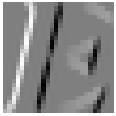

In [ ]:
out_unf = out_unf.view(26, 26)
show_image(out_unf);

In [ ]:
%timeit -n 1 tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])

32.6 ms ± 9.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit -n 100 (w@F.unfold(inp, (3, 3))[0]).view(26, 26);

193 µs ± 57.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit -n 100 F.conv2d(inp, left_edge[None, None])

The slowest run took 8.27 times longer than the fastest. This could mean that an intermediate result is being cached.
153 µs ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
diag1_edge = tensor([[0, -1, 1],
                     [-1, 1, 0],
                     [1,  0, 0]]).float()

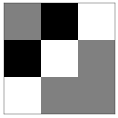

In [ ]:
show_image(diag1_edge, noframe=False);

In [ ]:
diag2_edge = tensor([[1, -1, 0],
                     [0, 1, -1],
                     [0, 0,  1]]).float()

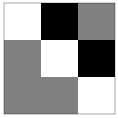

In [ ]:
show_image(diag2_edge, noframe=False);

In [ ]:
xb = x_imgs[:64][:, None]; xb.shape

torch.Size([64, 1, 28, 28])

In [ ]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:, None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [ ]:
batch_features = F.conv2d(xb, edge_kernels); batch_features.shape

torch.Size([64, 4, 26, 26])

The output shape shows we get 64 images in the mini-batch, 4 kernels, and 26x26 edge maps(we started with 28x28 images, but lost one pixel from each side as discussed earlier). We can see we get the same results as when we did this manually:

<AxesSubplot: >

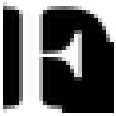

In [ ]:
img0 = xb[1, 0]
show_image(img0)

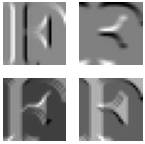

In [ ]:
show_images([batch_features[1, i] for i in range(4)])

## Strides and Padding

With appropriate padding, we can ensure that the output activation map is the same size as the original image.

<p align="center">
  <img src="images/chapter9_conv_pad.png" alt="Applying kernel of 3 by 3 on Grid of 5 by 5 with stride 1 along the first 3 rows">
</p>

With a 5x5 input, 4x4 kernel, and 2 pixels of padding, we end up with 6x6 activation map

<p align="center">
  <img src="images/att_00029.png" alt="Applying kernel of 4 by 4 on Grid of 5 by 5 with stride 1 and padding 2 to get a 6x6 activation map">
</p>


If we add a kernel of size `ks` by `ks` (with `ks` an odd number), the necessary padding on each side to keep the same shape is `ks//2`

We could move over two pixels after each kernel appliaction. This known as stride-2 convolution.
<p align="center">
  <img src="images/att_00030.png" alt="Applying kernel of 3 by 3 on Grid of 5 by 5 with stride 1 and padding 2 to get a 6x6 activation map">
</p>


## Creating the CNN

In [ ]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [ ]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [ ]:
tensor([np.product(o.shape) for o in model.parameters()]).sum()

tensor(39760)

In [ ]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 10, kernel_size=3, padding=1)
)

In [ ]:
l1 = nn.Conv2d(1, 30, kernel_size=3, padding=1)(xb); l1.shape

torch.Size([64, 30, 28, 28])

In [ ]:
l2 = nn.ReLU()(l1); l2.shape

torch.Size([64, 30, 28, 28])

In [ ]:
l3 = nn.Conv2d(30, 10, kernel_size=3, padding=1)(l2); l3.shape

torch.Size([64, 10, 28, 28])

In [ ]:
broken_cnn(xb).shape

torch.Size([64, 10, 28, 28])

In [ ]:
#|export
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

Refactoring parts of your neural networks like this makes it much less likely you'll get errors die to inconsistencies in your achitectures, and makes it more obvious to the reader which parts of your layers are actually hanging

In [ ]:
simple_cnn(xb).shape

torch.Size([64, 10])

In [ ]:
tensor([np.product(o.shape) for o in simple_cnn.parameters()]).sum()

tensor(5274)

In [ ]:
tensor([o.numel() for o in simple_cnn.parameters()]).sum()

tensor(5274)

In [ ]:
sum(o.numel() for o in simple_cnn.parameters())

5274

In [ ]:
x_imgs = x_train.view(-1, 1, 28, 28)
xv_imgs = x_valid.view(-1, 1, 28, 28)
train_ds, valid_ds = Dataset(x_imgs, y_train), Dataset(xv_imgs, y_valid)

In [ ]:
#|export

def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, Mapping): return {k: v.to(device) for k, v in x.items()}
    return type(x)(o.to(device) for o in x)

def collate_device(b): 
    return to_device(default_collate(b))

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
from torch import optim

bs = 256
lr = 0.4
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [ ]:
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 2.299301318205565 0.11508678216561774
1 2.280546821230085 0.12656875827880662
2 0.8789877557149717 0.733511349196746
3 0.6203243218531437 0.828304406511131
4 0.45614214779856366 0.8787716967559784


In [ ]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss, act = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.41114130928137593 0.8907877173220045
1 0.4039275900703247 0.8929238973058591
2 0.3920766551440485 0.8953271023740119
3 0.3823734535235111 0.8958611469720807
4 0.37331901976517906 0.9001335118896016


## Understanding Convolution Arithmetic

In an input size of `64x1x28x28` the axes are `batch, channel, height, width`. This is often represented as `NCHW` (where `N` refers to batch size). Tensorflow, on the hand, uses `NHWC` axis order (aka "channels-last"). Channels-last is faster for many models, so recently it's become more common to see this as option in PyTorch too.

In [ ]:
simple_cnn

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
conv1 = simple_cnn[0][0]
conv1.weight.shape

torch.Size([4, 1, 3, 3])

In [ ]:
conv1.bias.shape

torch.Size([4])

The _receptive field_ is the area of an image that is involved in the calculation of a layer. _conv-example.xlsx_ shows the calculation of two stride-2 convolutional layers using an MNIST digit. Here's what we see if we click on one of the cells in the _conv2_ section, which shows the output of the second convolutional layer, and click _trace precedents_

<p align="center">
  <img src="images/att_00068.png" alt="Applying filter of 3 by 3 to conv1 to get values in conv2">
</p>

The blue highlighted cells are its _precedents*--that is, the cells used to calculate its value. These cells are the corresponding 3x3 area of cells from the input layer (on the left), and the cells from the filter (on the right). Click *trace precedents_ again

## Export

In [ ]:
from nbdev import nbdev_export; nbdev_export()